In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from fbprophet import Prophet


%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
plant1_generation = pd.read_csv('../input/solar-power-generation-data/Plant_1_Generation_Data.csv')
plant1_weather = pd.read_csv('../input/solar-power-generation-data/Plant_1_Weather_Sensor_Data.csv')
plant2_generation = pd.read_csv('../input/solar-power-generation-data/Plant_2_Generation_Data.csv')
plant2_weather = pd.read_csv('../input/solar-power-generation-data/Plant_2_Weather_Sensor_Data.csv')

In [3]:
plant1_generation.head()

DATE_TIME  PLANT_ID       SOURCE_KEY  DC_POWER  AC_POWER  \
0  15-05-2020 00:00   4135001  1BY6WEcLGh8j5v7       0.0       0.0   
1  15-05-2020 00:00   4135001  1IF53ai7Xc0U56Y       0.0       0.0   
2  15-05-2020 00:00   4135001  3PZuoBAID5Wc2HD       0.0       0.0   
3  15-05-2020 00:00   4135001  7JYdWkrLSPkdwr4       0.0       0.0   
4  15-05-2020 00:00   4135001  McdE0feGgRqW7Ca       0.0       0.0   

   DAILY_YIELD  TOTAL_YIELD  
0          0.0    6259559.0  
1          0.0    6183645.0  
2          0.0    6987759.0  
3          0.0    7602960.0  
4          0.0    7158964.0

In [4]:
plant2_weather.tail()

DATE_TIME  PLANT_ID       SOURCE_KEY  AMBIENT_TEMPERATURE  \
3254  2020-06-17 22:45:00   4136001  iq8k7ZNt4Mwm3w0            23.511703   
3255  2020-06-17 23:00:00   4136001  iq8k7ZNt4Mwm3w0            23.482282   
3256  2020-06-17 23:15:00   4136001  iq8k7ZNt4Mwm3w0            23.354743   
3257  2020-06-17 23:30:00   4136001  iq8k7ZNt4Mwm3w0            23.291048   
3258  2020-06-17 23:45:00   4136001  iq8k7ZNt4Mwm3w0            23.202871   

      MODULE_TEMPERATURE  IRRADIATION  
3254           22.856201          0.0  
3255           22.744190          0.0  
3256           22.492245          0.0  
3257           22.373909          0.0  
3258           22.535908          0.0

# Questions
- Can we predict the power generation for next couple of days? - this allows for better grid management

We can try, I'm inclined to use fbprophet for this as we have weekly data

- Can we identify the need for panel cleaning/maintenance?
- Can we identify faulty or suboptimally performing equipment?

I feel like these two questions go together. The way to identify a need for maintenance or fault detection is to build a trend of normal system performance (power output) in a given set of environmental conditions (time of day, weather etc). Any fall in power output indicates a need for maintenance/cleaning or the occurance of a fault. As we only have a month of data, this will be challenging to do properly...but I can explore how it could be done

# Visualisation

Lets look at the data and see if anything can be gleaned from it

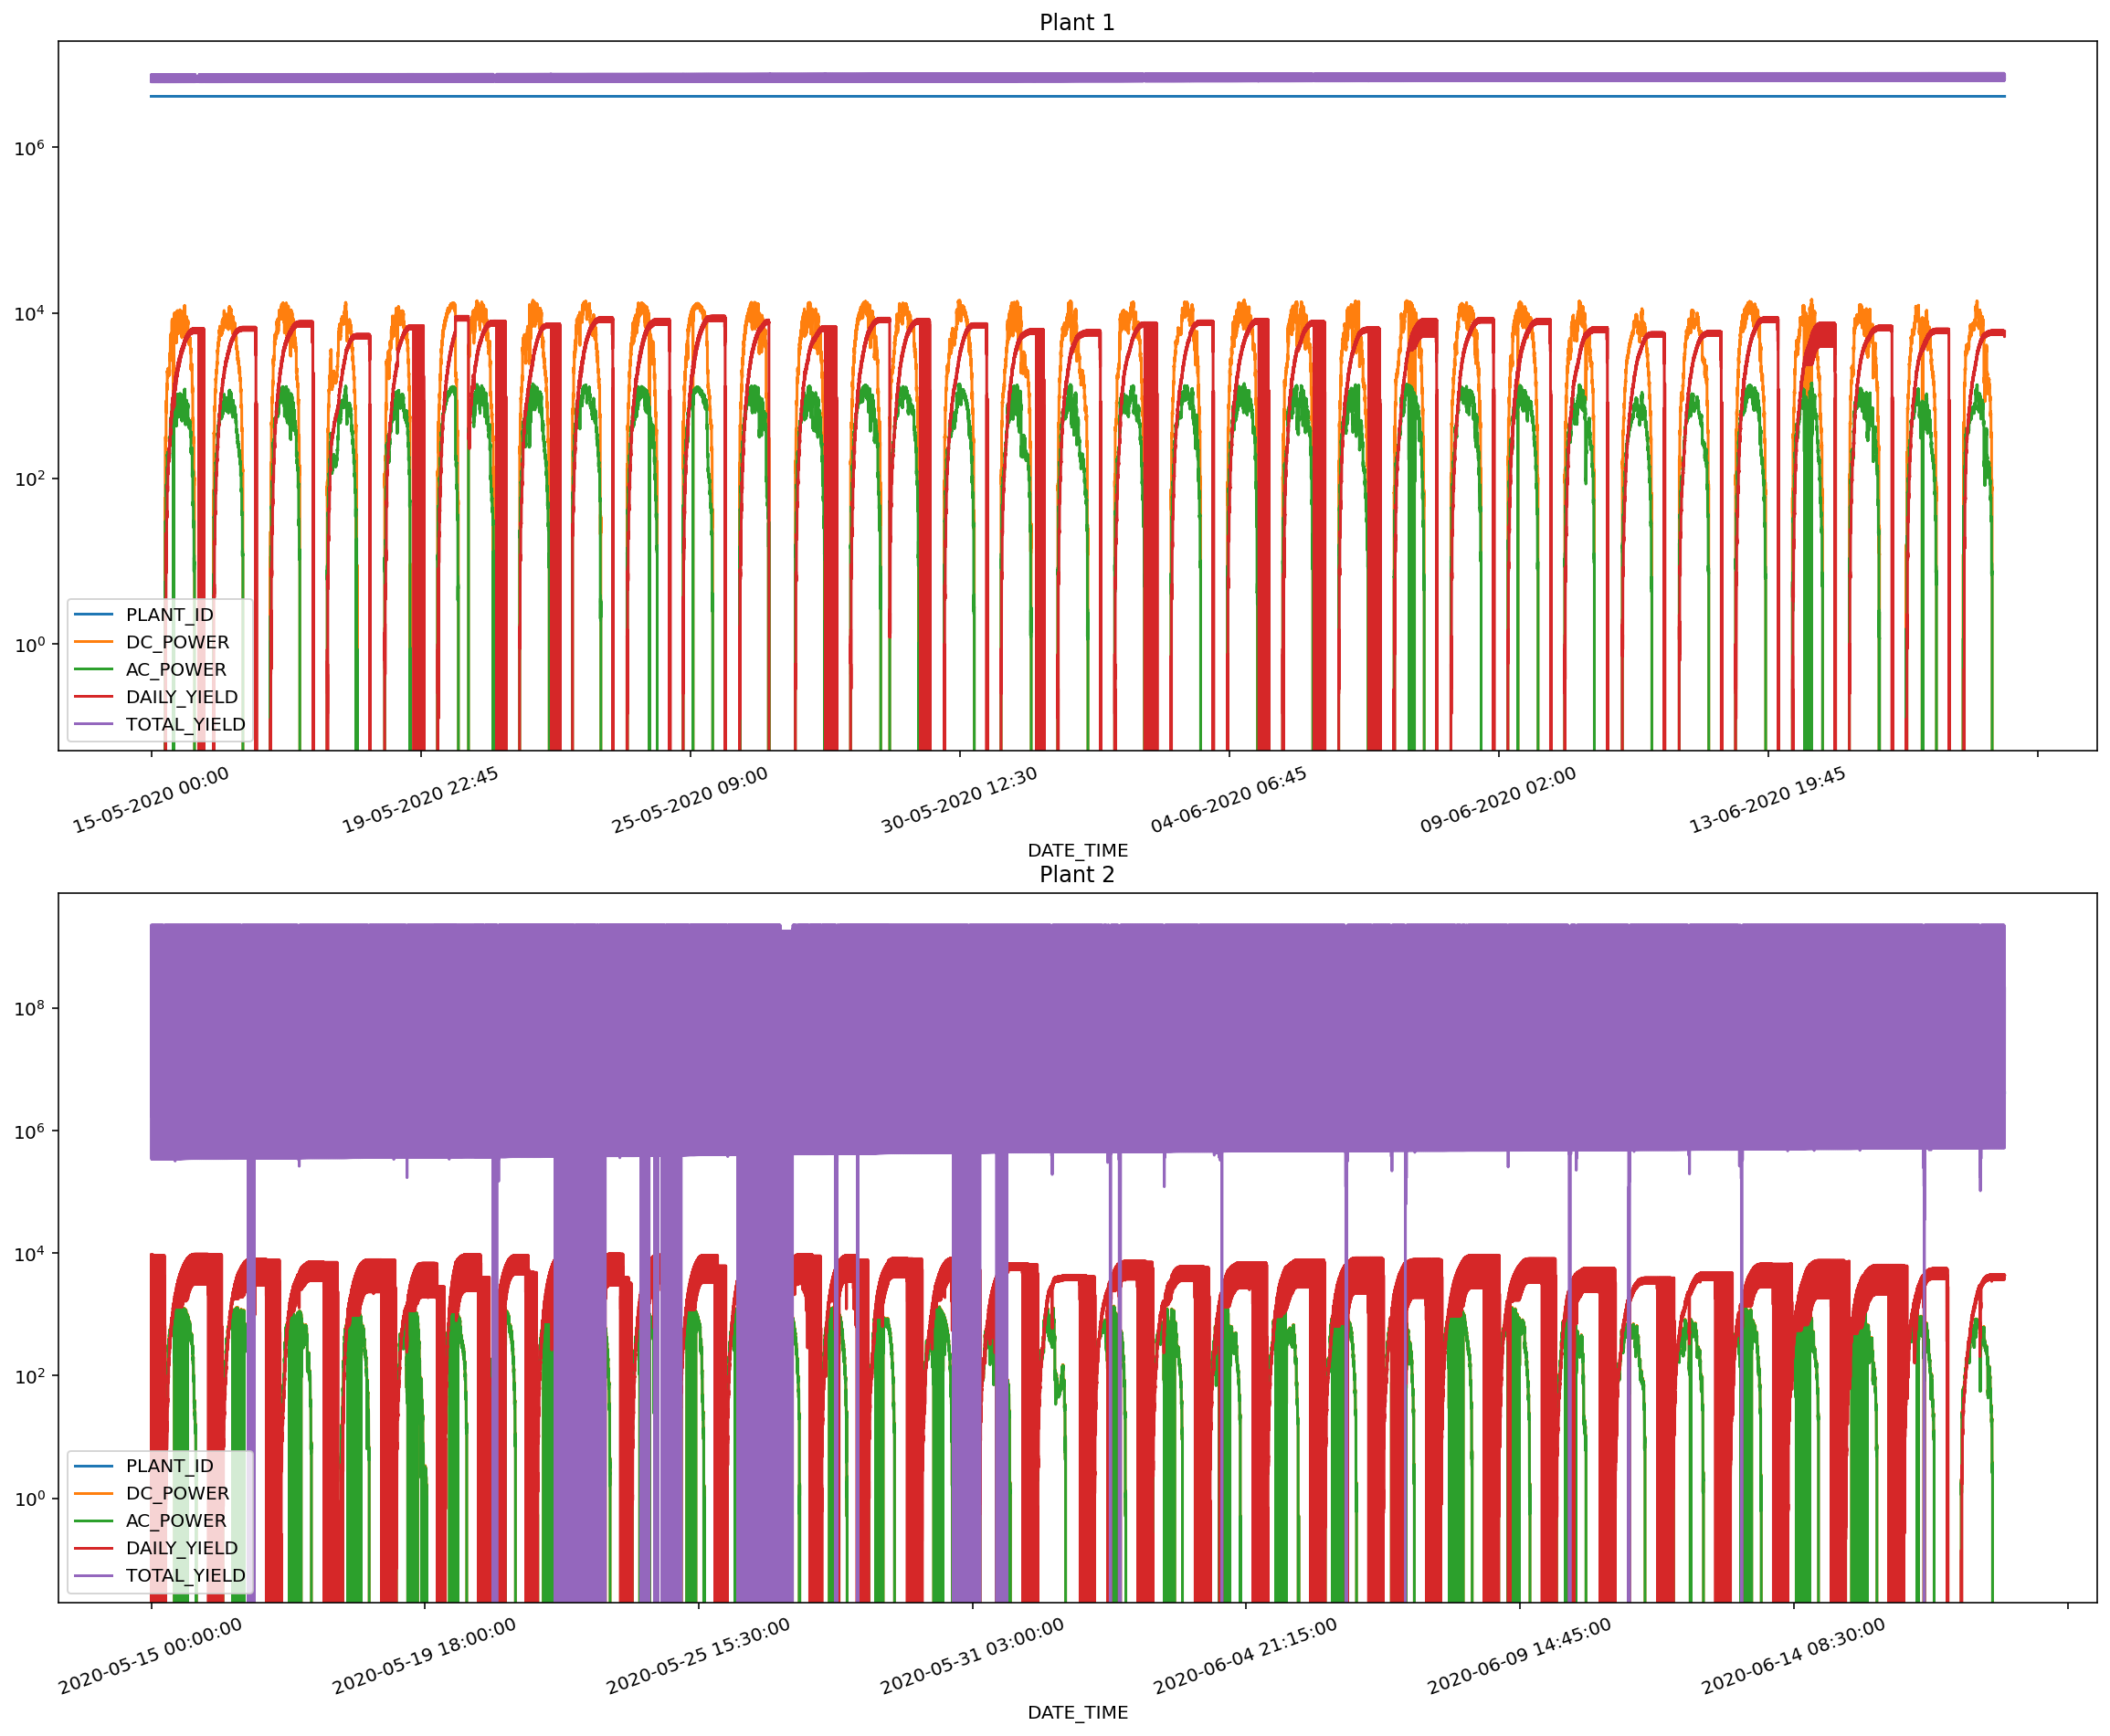

In [5]:
fig, axes = plt.subplots(nrows = 2, sharex=False, figsize=(20, 5))
fig.subplots_adjust(top = 2.5)
ax = plant1_generation.plot(x = 'DATE_TIME', logy = True, title = 'Plant 1', rot = 20, ax = axes[0]); 
ax = plant2_generation.plot(x = 'DATE_TIME', logy = True, title = 'Plant 2', rot = 20, ax = axes[1]); 

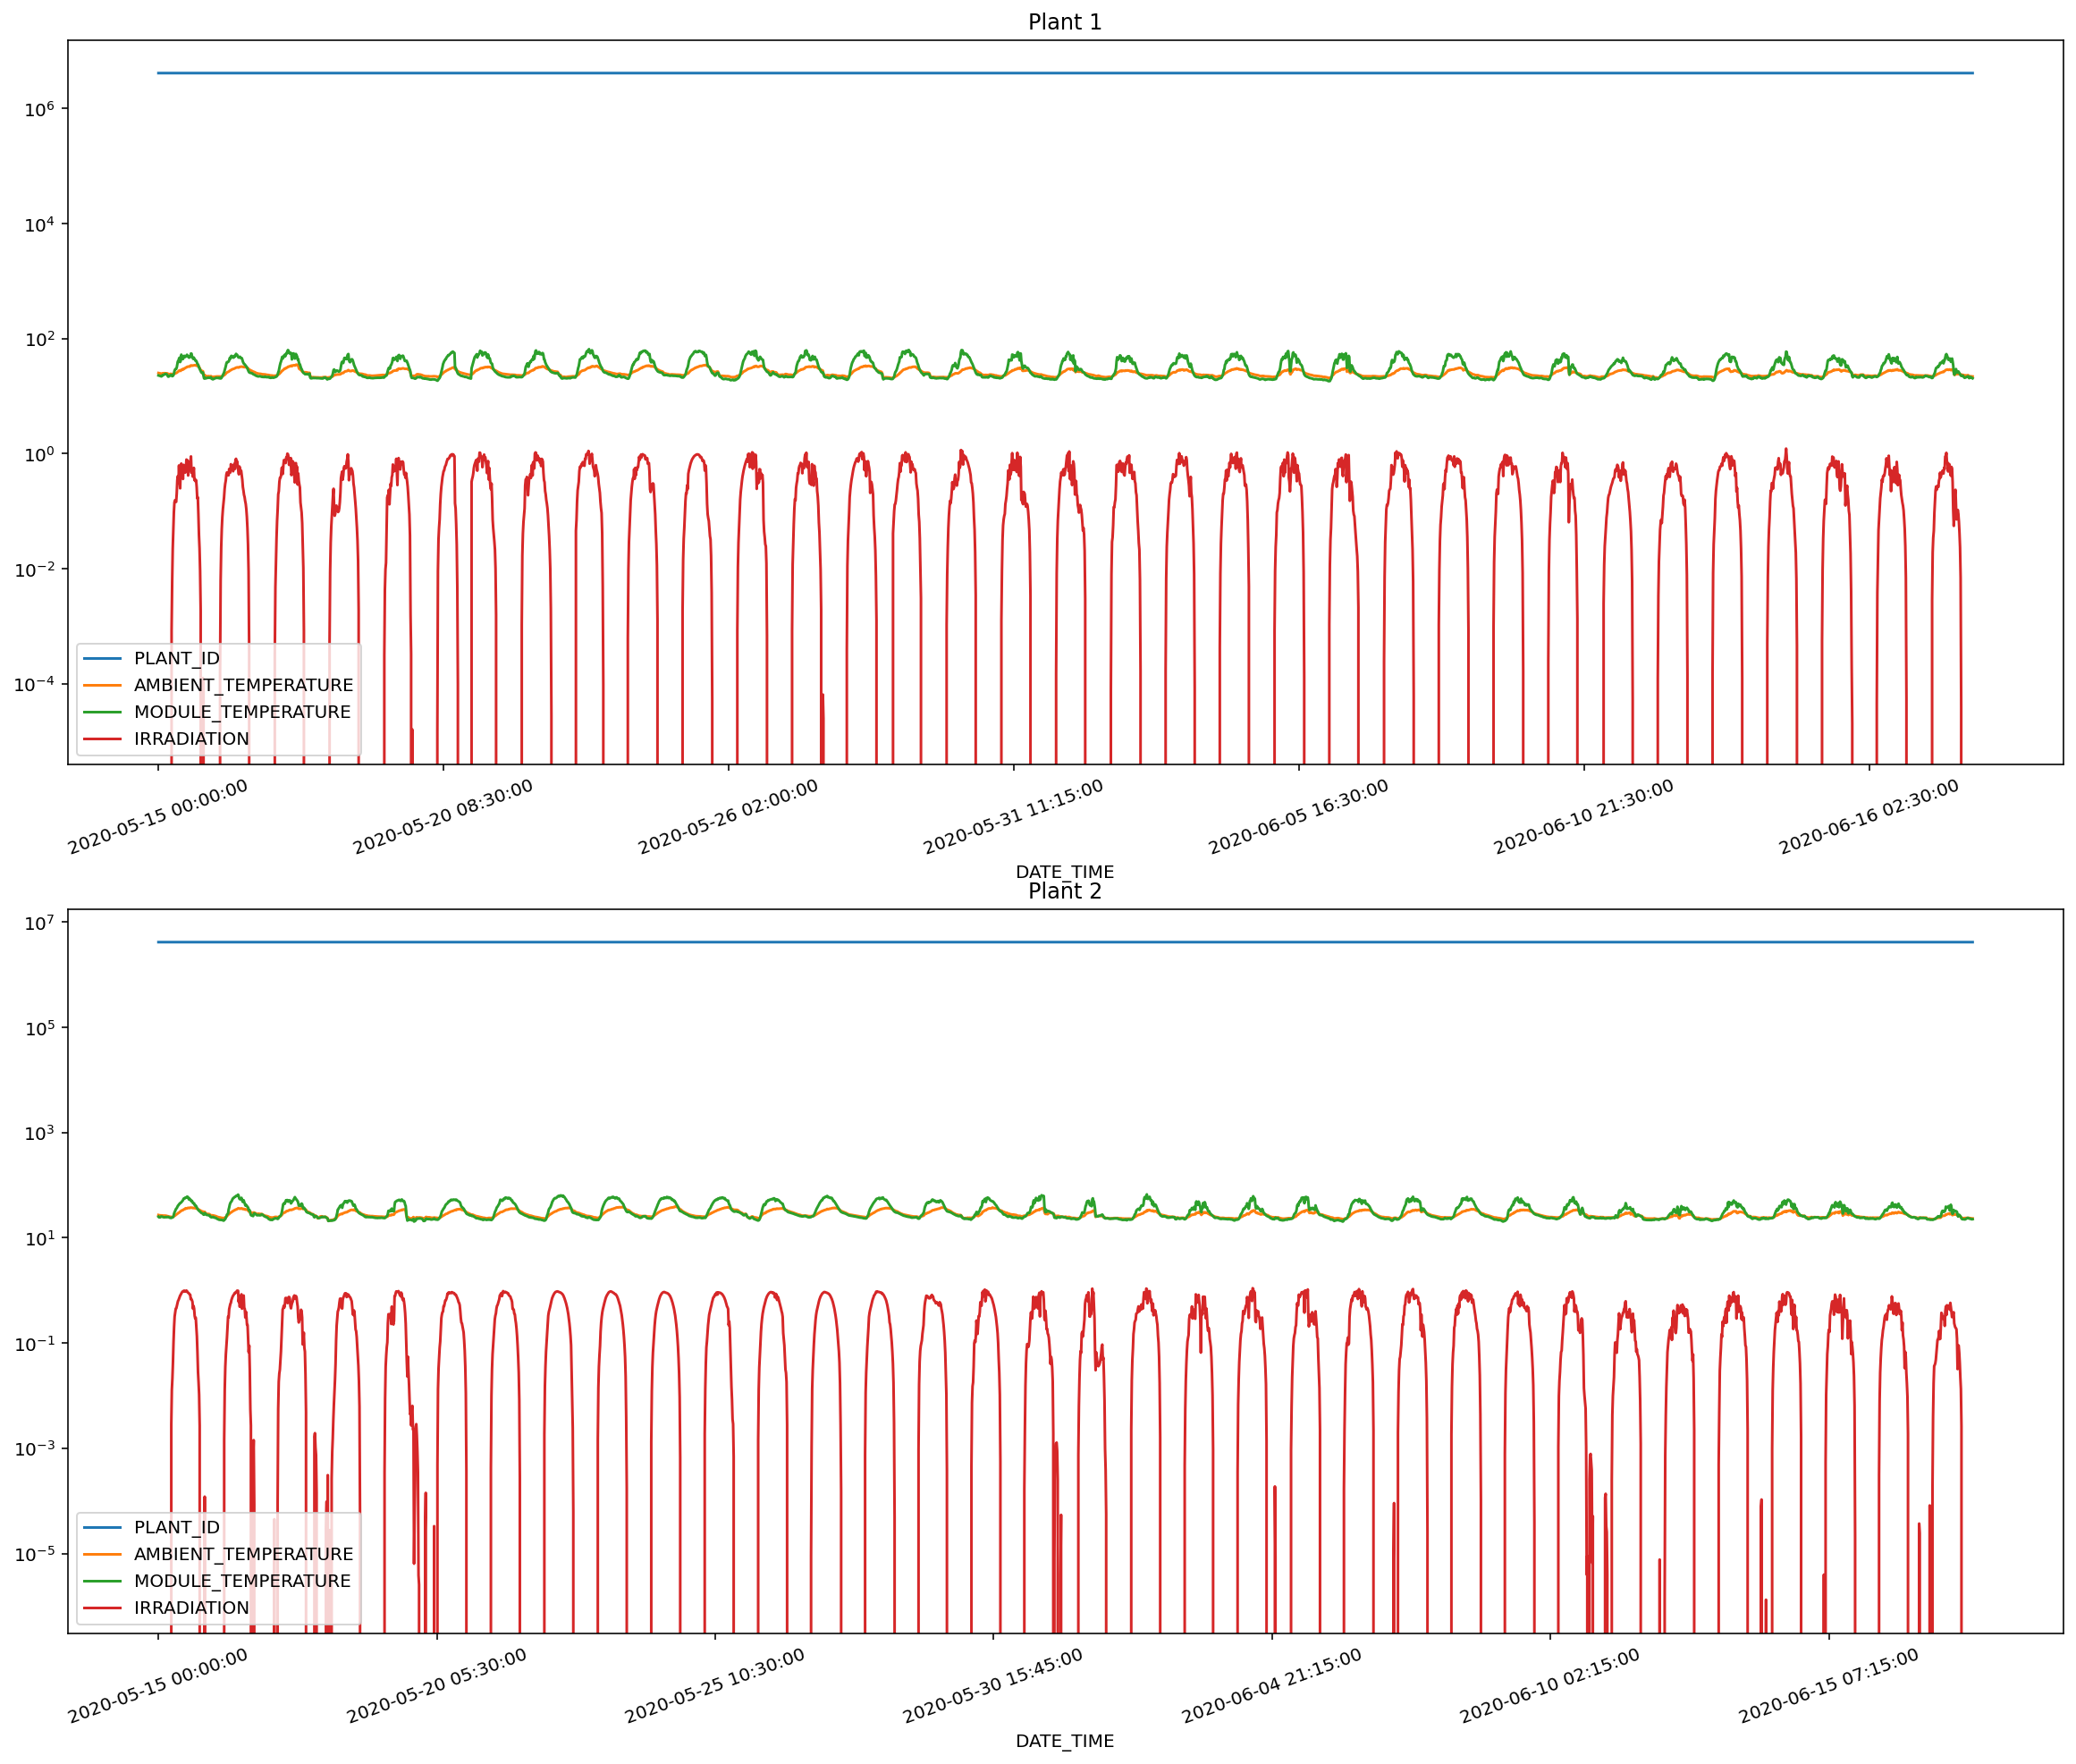

In [6]:
fig, axes = plt.subplots(nrows = 2, sharex=False, figsize=(20, 5))
fig.subplots_adjust(top = 2.6)
ax = plant1_weather.plot(x = 'DATE_TIME', logy = True, title = 'Plant 1', rot = 20, ax = axes[0]); 
ax = plant2_weather.plot(x = 'DATE_TIME', logy = True, title = 'Plant 2', rot = 20, ax = axes[1]); 

- From the plots above we see distinct peaks in power output, irradiation and temperature, rising and falling with the sun each day
- We can also see in the comparisons between plant 1 and plant 2, that for plant 1 TOTAL_YIELD is consistently > ~10^6 whilst for plant 2 TOTAL_YIELD varies dramatically with several interludes where it falls to zero and at other times in the 10^6 - >10^8 range. 
- Daily weather trends on the other hand appear superficially similar between plant 1 and plant 2

#### Let's compare the distributions of some of these features between the two plants

In [7]:
power_metrics =  plant1_generation.columns[3:]
weather_metrics = plant1_weather.columns[3:]

In [8]:
print(power_metrics)
print(weather_metrics)

Index(['DC_POWER', 'AC_POWER', 'DAILY_YIELD', 'TOTAL_YIELD'], dtype='object')
Index(['AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION'], dtype='object')


/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

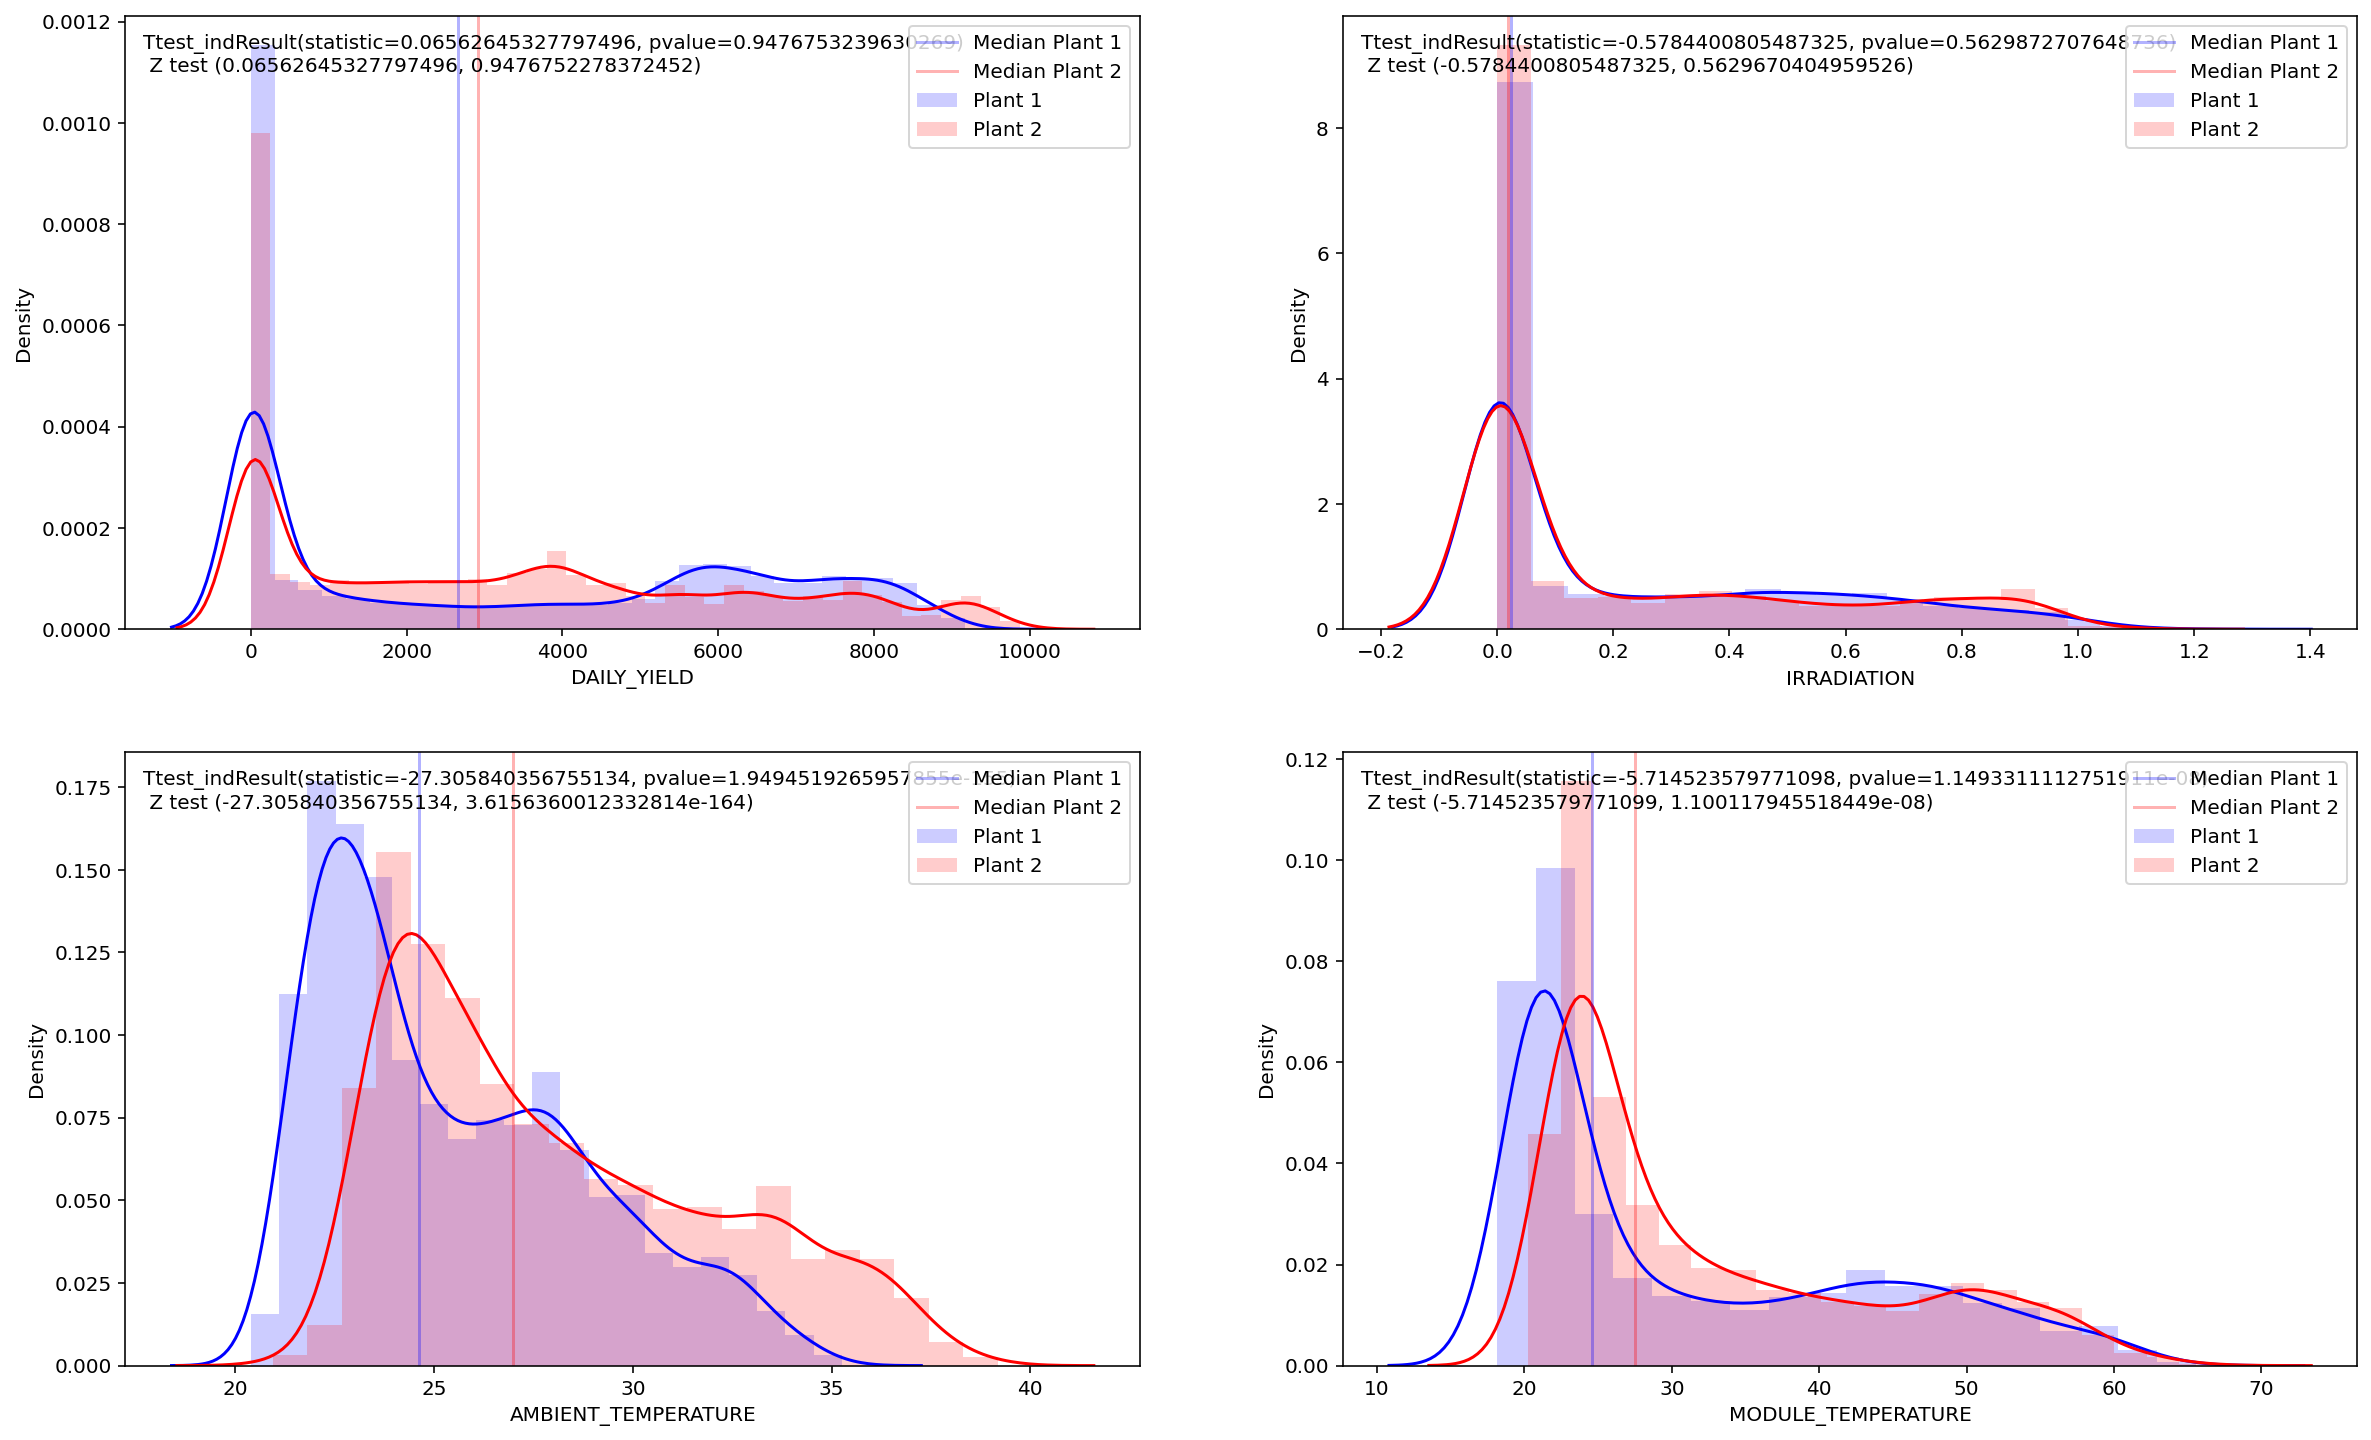

In [9]:
# Overlay of TOTAL_YIELD for plant 1 vs plant 2, with IRRADIATION for plant 1 vs plant 2 next to it
# ANOVA for both plant 1 v 2 comparisons below
from scipy import stats
from matplotlib.offsetbox import AnchoredText
from statsmodels.stats.weightstats import ztest

DY_t = stats.ttest_ind(plant1_generation['DAILY_YIELD'],plant2_generation['DAILY_YIELD'])
DY_z = ztest(plant1_generation['DAILY_YIELD'],plant2_generation['DAILY_YIELD'])
# DY_v_1, DY_v_2 = np.var(plant1_generation['DAILY_YIELD']), np.var(plant2_generation['DAILY_YIELD'])
DY_m_1, DY_m_2 = plant1_generation['DAILY_YIELD'].median(), plant2_generation['DAILY_YIELD'].median()

IR_t = stats.ttest_ind(plant1_weather['IRRADIATION'],plant2_weather['IRRADIATION'])
IR_z = ztest(plant1_weather['IRRADIATION'],plant2_weather['IRRADIATION'])
IR_m_1, IR_m_2 = plant1_weather['IRRADIATION'].median(), plant2_weather['IRRADIATION'].median()

AT_t = stats.ttest_ind(plant1_weather['AMBIENT_TEMPERATURE'],plant2_weather['AMBIENT_TEMPERATURE'])
AT_z = ztest(plant1_weather['AMBIENT_TEMPERATURE'],plant2_weather['AMBIENT_TEMPERATURE'])
AT_m_1, AT_m_2 = plant1_weather['AMBIENT_TEMPERATURE'].median(), plant2_weather['AMBIENT_TEMPERATURE'].median()

MT_t = stats.ttest_ind(plant1_weather['MODULE_TEMPERATURE'],plant2_weather['MODULE_TEMPERATURE'])
MT_z = ztest(plant1_weather['MODULE_TEMPERATURE'],plant2_weather['MODULE_TEMPERATURE'])
MT_m_1, MT_m_2 = plant1_weather['MODULE_TEMPERATURE'].median(), plant2_weather['MODULE_TEMPERATURE'].median()

fig, axes = plt.subplots(ncols = 2, nrows = 2, sharex=False, figsize=(20, 5))
fig.subplots_adjust(top = 2)
Alpha = 0.3

anc1 = AnchoredText(f"{DY_t}\n Z test {DY_z}", loc="upper left", frameon=False)
ax1 = sns.distplot(plant1_generation['DAILY_YIELD'], ax=axes[0,0], color = 'b', label = 'Plant 1', hist_kws=dict(alpha=0.2))
ax1 = sns.distplot(plant2_generation['DAILY_YIELD'], ax=axes[0,0], color = 'r', label = 'Plant 2', hist_kws=dict(alpha=0.2))
fig.axes[0].axvline(DY_m_1, color = 'b', alpha=Alpha, label = 'Median Plant 1')
fig.axes[0].axvline(DY_m_2, color = 'r', alpha=Alpha, label = 'Median Plant 2')
ax1.add_artist(anc1)
ax1.legend()

anc2 = AnchoredText(f"{IR_t}\n Z test {IR_z}", loc="upper left", frameon=False)
ax2 = sns.distplot(plant1_weather['IRRADIATION'], ax=axes[0,1], color = 'b', label = 'Plant 1', hist_kws=dict(alpha=0.2))
ax2 = sns.distplot(plant2_weather['IRRADIATION'], ax=axes[0,1], color = 'r', label = 'Plant 2', hist_kws=dict(alpha=0.2))
fig.axes[1].axvline(IR_m_1, color = 'b', alpha=Alpha, label = 'Median Plant 1')
fig.axes[1].axvline(IR_m_2, color = 'r', alpha=Alpha, label = 'Median Plant 2')
ax2.add_artist(anc2)
ax2.legend()

anc3 = AnchoredText(f"{AT_t}\n Z test {AT_z}", loc="upper left", frameon=False)
ax3 = sns.distplot(plant1_weather['AMBIENT_TEMPERATURE'], ax=axes[1,0], color = 'b', label = 'Plant 1', hist_kws=dict(alpha=0.2))
ax3 = sns.distplot(plant2_weather['AMBIENT_TEMPERATURE'], ax=axes[1,0], color = 'r', label = 'Plant 2', hist_kws=dict(alpha=0.2))
fig.axes[2].axvline(AT_m_1, color = 'b', alpha=Alpha, label = 'Median Plant 1')
fig.axes[2].axvline(AT_m_2, color = 'r', alpha=Alpha, label = 'Median Plant 2')
ax3.add_artist(anc3)
ax3.legend()

anc4 = AnchoredText(f"{MT_t}\n Z test {MT_z}", loc="upper left", frameon=False)
ax4 = sns.distplot(plant1_weather['MODULE_TEMPERATURE'], ax=axes[1,1], color = 'b', label = 'Plant 1', hist_kws=dict(alpha=0.2))
ax4 = sns.distplot(plant2_weather['MODULE_TEMPERATURE'], ax=axes[1,1], color = 'r', label = 'Plant 2', hist_kws=dict(alpha=0.2))
fig.axes[3].axvline(MT_m_1, color = 'b', alpha=Alpha, label = 'Median Plant 1')
fig.axes[3].axvline(MT_m_2, color = 'r', alpha=Alpha, label = 'Median Plant 2')
ax4.add_artist(anc4)
ax4.legend();

- From the distributions and Z test results above we can see that although the mean DAILY_YIELD of the two plants is similar; however the median DAILY_YIELD for plant 2 is higher
- The levels of IRRADIATION between the two plants are very similar, though plant 2 has slightly higher irradiation levels > ~0.8
- AMBIENT_TEMPERATURE and MODULE_TEMPERATURE are more variable between plant 1 and plant 2
- Plant 2 has a warmer AMBIENT_TEMPERATURE and MODULE_TEMPERATURE on average. 
- Could these occasional days where ambient temperature rises above 35degC and the higher average module temperature, be the reason for the fluctuations in TOTAL_YIELD seen from plant 2? Perhaps the equipment is over-heating causing it to be less efficient or fail when its preferred operational temperature is exceeded?

# Forecasting Power Output With Facebook Prophet

- Prophet conducts a form of Bayesian time series forecasting, modelling the change in your chosen variable y, with respect to time, using the following summation:

$y(t) = g(t) + s(t) + h(t) + \epsilon_t \tag{1}$

- $ g(t) $ refers to a piece-wise linear/logistic growth model, $ s(t) $ captures seasonality effects, $ h(t) $ models special events (fb calls them holidays) and $\epsilon_t$ models the error
- This type of model is called a generalised additive model and to learn more and build this from scratch in PyMC3, I recommend this link:
https://www.ritchievink.com/blog/2018/10/09/build-facebooks-prophet-in-pymc3-bayesian-time-series-analyis-with-generalized-additive-models/

In [10]:
df = plant2_generation.copy()  
df.rename(columns= {'DATE_TIME':'ds', 'DAILY_YIELD': 'y'}, inplace = True)
m = Prophet(daily_seasonality=True, weekly_seasonality = True, yearly_seasonality = False)
m.fit(df)
future = m.make_future_dataframe(periods=30)
forecast = m.predict(future)

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


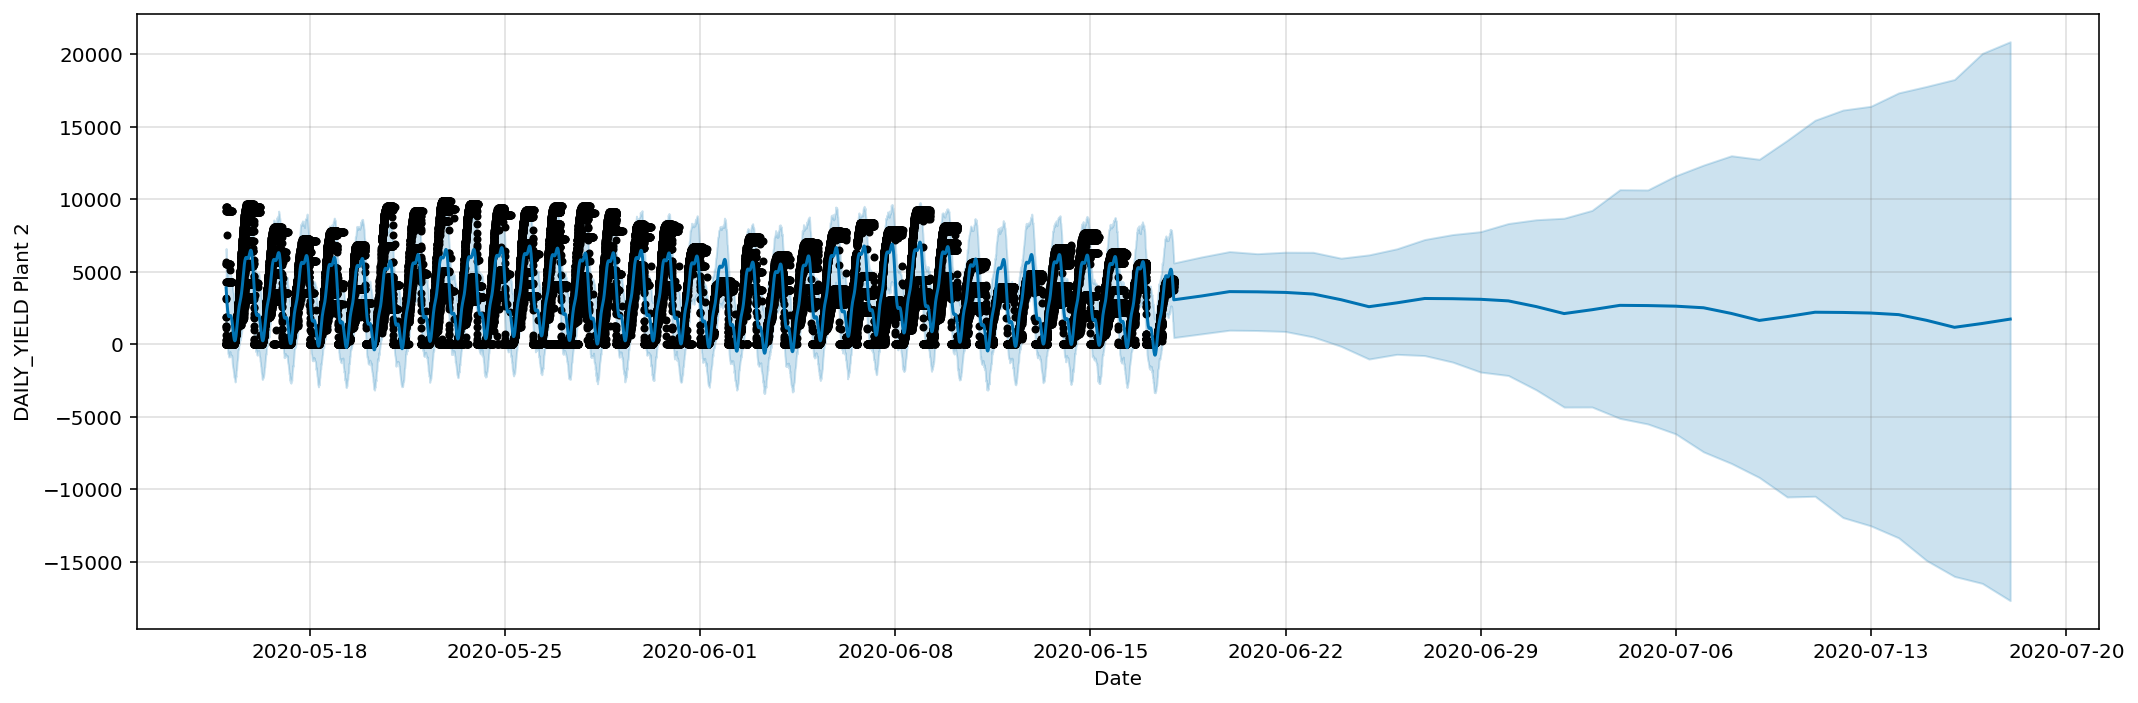

In [11]:
fig1 = m.plot(forecast, xlabel='Date', ylabel='DAILY_YIELD Plant 2',figsize = (15,5))
ax = fig.gca()
ax.set_title("DAILY_YIELD Forecast", size=34)
ax.set_xlabel("X", size=34)
ax.set_ylabel("Y", size=34)
ax.tick_params(axis="x", labelsize=24)
ax.tick_params(axis="y", labelsize=24)

- From the forecast above we can see that the expected trend of DAILY_YIELD for plant 2 is for a slight decline in yield over the next week
- The confidence interval in blue, indicates that the forecast is less certain, the further away from the present we go
- The model has been set up to look for weekly seasonality, which it appears to have captured in its forecast

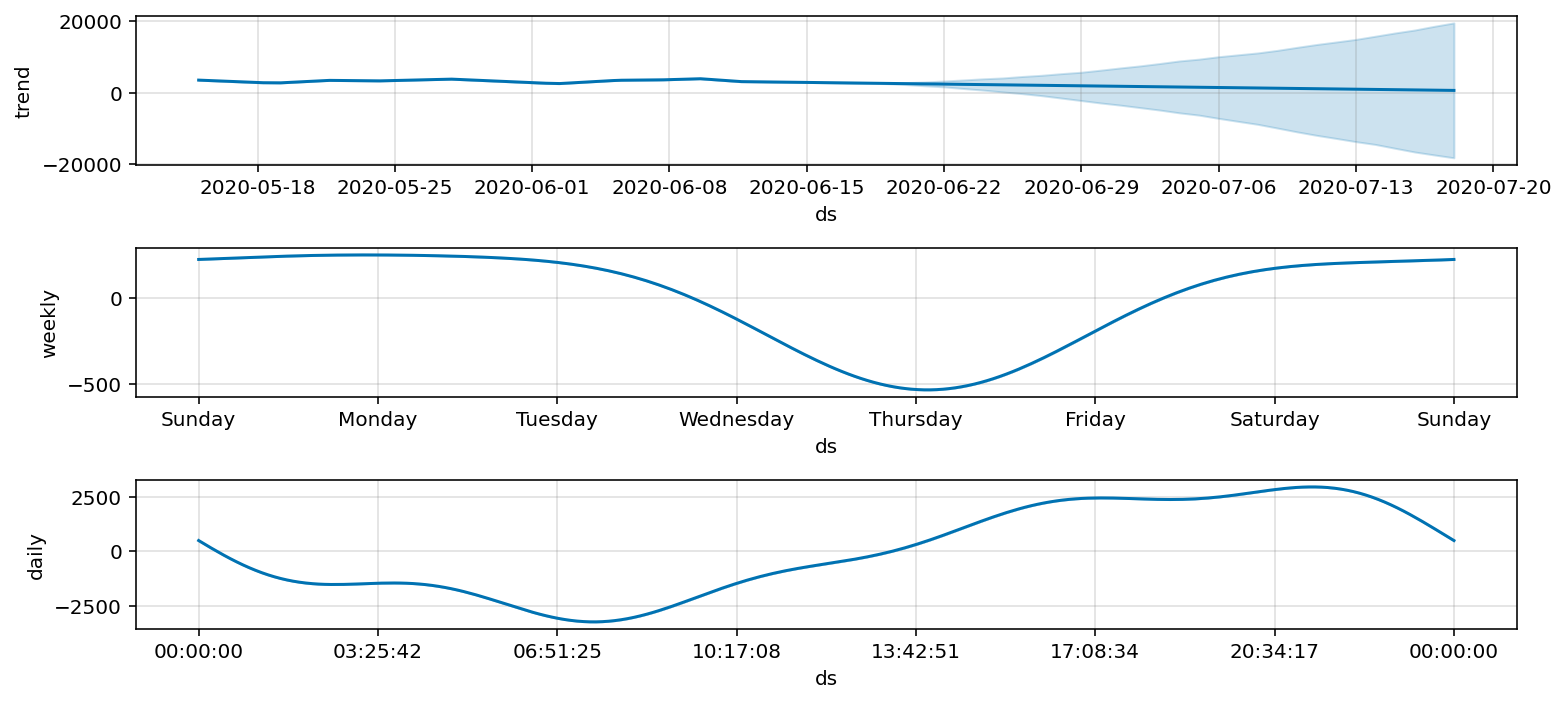

In [12]:
fig2 = m.plot_components(forecast, figsize = (11,5))

- In the forecast plots above we can see again the slight downward trend in DAILY_YIELD for the coming week, as well as a tendency for lower DAILY_YIELD on Thursdays seen in the weekly trend
- As expected DAILY_YIELD rises from ~7am onwards with the sun and maxes out by ~9pm each day 

# Detecting anomalous MODULE_TEMPERATURE with Facebook Prophet

- Aside from setting thresholds, whereby if a value is crossed an anomaly is registered, more sophisticated time series anomaly detection can be achieved using models which capture the trend in the data through time and assign confidence intervals, outside of which values are classed as anomalies

- fbprophet can also be used for anomaly detection quite easily
https://facebook.github.io/prophet/docs/outliers.html

- Using the yhat_lower and yhat_upper values (the confidence intervals of the fit model) as thresholds, we can mark any values falling above or below them as "anomalous" values, whilst capturing the normal variation of the time-series

- Many thanks to the authors of https://towardsdatascience.com/anomaly-detection-time-series-4c661f6f165f and https://www.mikulskibartosz.name/prophet-plot-explained/ for the starter code used in this section

In [13]:
df2 = plant2_weather.copy()  
df2.rename(columns= {'DATE_TIME':'ds', 'MODULE_TEMPERATURE': 'y'}, inplace = True)

In [14]:
def fit_predict_model(dataframe, interval_width = 0.9, changepoint_range = 0.8):
    m = Prophet(daily_seasonality = True, yearly_seasonality = False, weekly_seasonality = True,
                seasonality_mode = 'multiplicative', 
                interval_width = interval_width,
                changepoint_range = changepoint_range)
    m = m.fit(dataframe)
    
    forecast = m.predict(dataframe)
    forecast['fact'] = dataframe['y'].reset_index(drop = True)
    #fig1 = m.plot(forecast, figsize = (30, 5));
    return forecast
    
pred = fit_predict_model(df2)

In [15]:
def detect_anomalies(forecast):
    forecasted = forecast[['ds','trend', 'yhat', 'yhat_lower', 'yhat_upper', 'fact']].copy()
    #forecast['fact'] = df['y']

    forecasted['anomaly'] = 0
    forecasted.loc[forecasted['fact'] > forecasted['yhat_upper'], 'anomaly'] = 1
    forecasted.loc[forecasted['fact'] < forecasted['yhat_lower'], 'anomaly'] = -1

    #anomaly importances
    forecasted['importance'] = 0
    forecasted.loc[forecasted['anomaly'] ==1, 'importance'] = \
        (forecasted['fact'] - forecasted['yhat_upper'])/forecast['fact']
    forecasted.loc[forecasted['anomaly'] ==-1, 'importance'] = \
        (forecasted['yhat_lower'] - forecasted['fact'])/forecast['fact']
    
    forecasted['MODULE_TEMPERATURE'] = forecasted['fact']
    return forecasted

pred = detect_anomalies(pred)

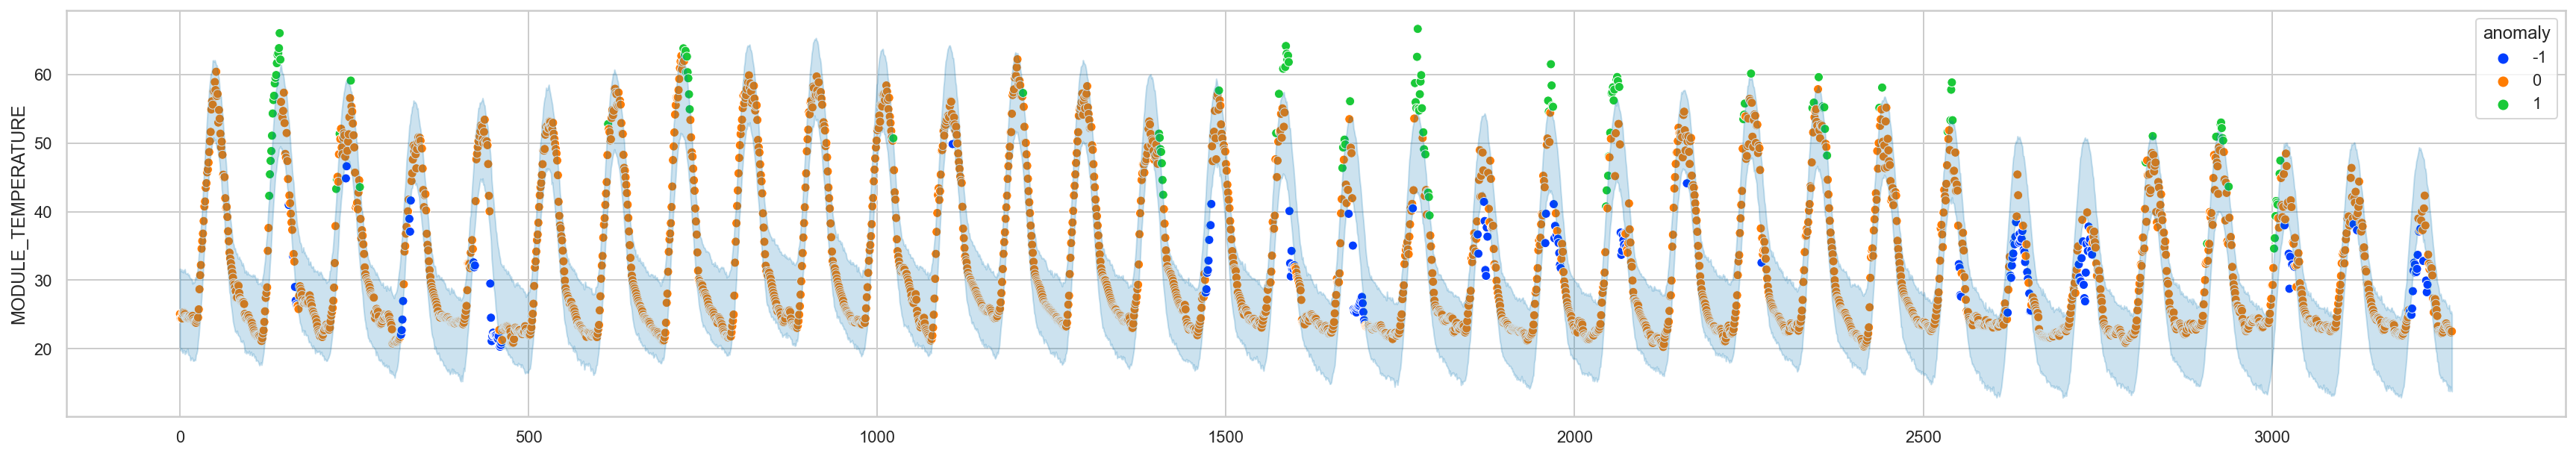

In [16]:
sns.set(style="whitegrid")
fig, axes = plt.subplots(ncols = 1, nrows = 1, sharex=False, figsize=(30, 5))
ax = sns.scatterplot(x = pred.index, y = pred['MODULE_TEMPERATURE'], hue = pred['anomaly'], ax=axes, palette = 'bright')
ax = ax.fill_between(pred.index, pred['yhat_lower'], pred['yhat_upper'],color='#0072B2', alpha=0.2)

- An anomaly detection such as this, would allow the operators at the solar plants to identify spikes or drops in MODULE_TEMPERATURE which may be indicative of faults or suboptimal operating conditions and allow them to react accordingly

# Conclusions

- By looking at the distributions we can see clearly that plant 1 and plant 2 are operating in somewhat different environmental conditions. Plant 2 operates in a higher ambient temperature on average, which may put a strain on the equipment, perhap explaining some of it's unusual fluctuations in TOTAL_YIELD
- Using forecasting methods it should definitely be possible to predict likely power outputs for the following week from data such as this. In order to capture larger seasonal trends over the course of a year, one would need a few years worth of training data (ideally though one year might do). fbprophet is a great library for quick and easy time-series forecasting
- Anomaly detection systems can be built from various time series models, provided the models generate confidence intervals which may be use for setting meaningful thresholds. Many approaches exist to capturing the normal trend and variation of the time series and outputting confidence intervals for anomaly detection but the fbprophet one seems to do the job here, given that we have daily/weekly trended data. The sensitivity of any anomaly detection system may be arbitrarily tuned to define "anomalous" data points as being more or less dramatically different from the normal time series trend and this requires some domain knowledge of the system to setup